# PyTorch EO Semantic Segmentation Example
## Step 5: Model Inference
*Rob Knapen, Wageningen Environmental Research*
<br>

This notebook provides an example of using a trained model that has been converted to TorchScript for inference, taking a geotiff file as input. GDAL is used to read and write geotiff files, since we want to be able to convert the method to C++ in the end.

At the end of the notebook it is shown how a subset of the input data can be extracted, normalized, and written to a CSV file. This can be used for testing and comparing the inference results on small datasets.

In [1]:
import torch
from osgeo import gdal

import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt

%matplotlib inline

## Load a read-to-go TorchScript model

In [2]:
# files to processing

# torchscript trained model to use for inference
model_file = "../models/rvo_crops_segnet_224x224x28_77classes_100epochs_model_full_traced.pt"
# input file, should match model dimensions and data pre-processing
input_file = "../data/raw/sentinel2_2018_flevopolder_10m_7x4bands.tif"
# groundtruth data, which was used for training the model
groundtruth_file = "../data/raw/brpparcels_2018_flevopolder_10m_76classes.tif"

In [3]:
# load the torchscript model
model = torch.jit.load(model_file)
print(model)

RecursiveScriptModule(
  original_name=SegNet
  (maxpool): RecursiveScriptModule(original_name=MaxPool2d)
  (unpool): RecursiveScriptModule(original_name=MaxUnpool2d)
  (c1): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=BatchNorm2d)
    (2): RecursiveScriptModule(original_name=ReLU)
  )
  (c2): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=BatchNorm2d)
    (2): RecursiveScriptModule(original_name=ReLU)
  )
  (c3): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=BatchNorm2d)
    (2): RecursiveScriptModule(original_name=ReLU)
  )
  (c4): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_na

## Examine the input dataset

In [4]:
# visualise the input file using rasterio
input_ds = rasterio.open(input_file)

print('Input image width   :', input_ds.width)
print('Input image height  :', input_ds.height)
print('Input image bounds  :', input_ds.bounds)
print('Input image indexes :', input_ds.indexes)
print('Input dataset shape :', input_ds.read().shape)

Input image width   : 5490
Input image height  : 2170
Input image bounds  : BoundingBox(left=674900.0, bottom=5832260.0, right=729800.0, top=5853960.0)
Input image indexes : (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28)
Input dataset shape : (28, 2170, 5490)


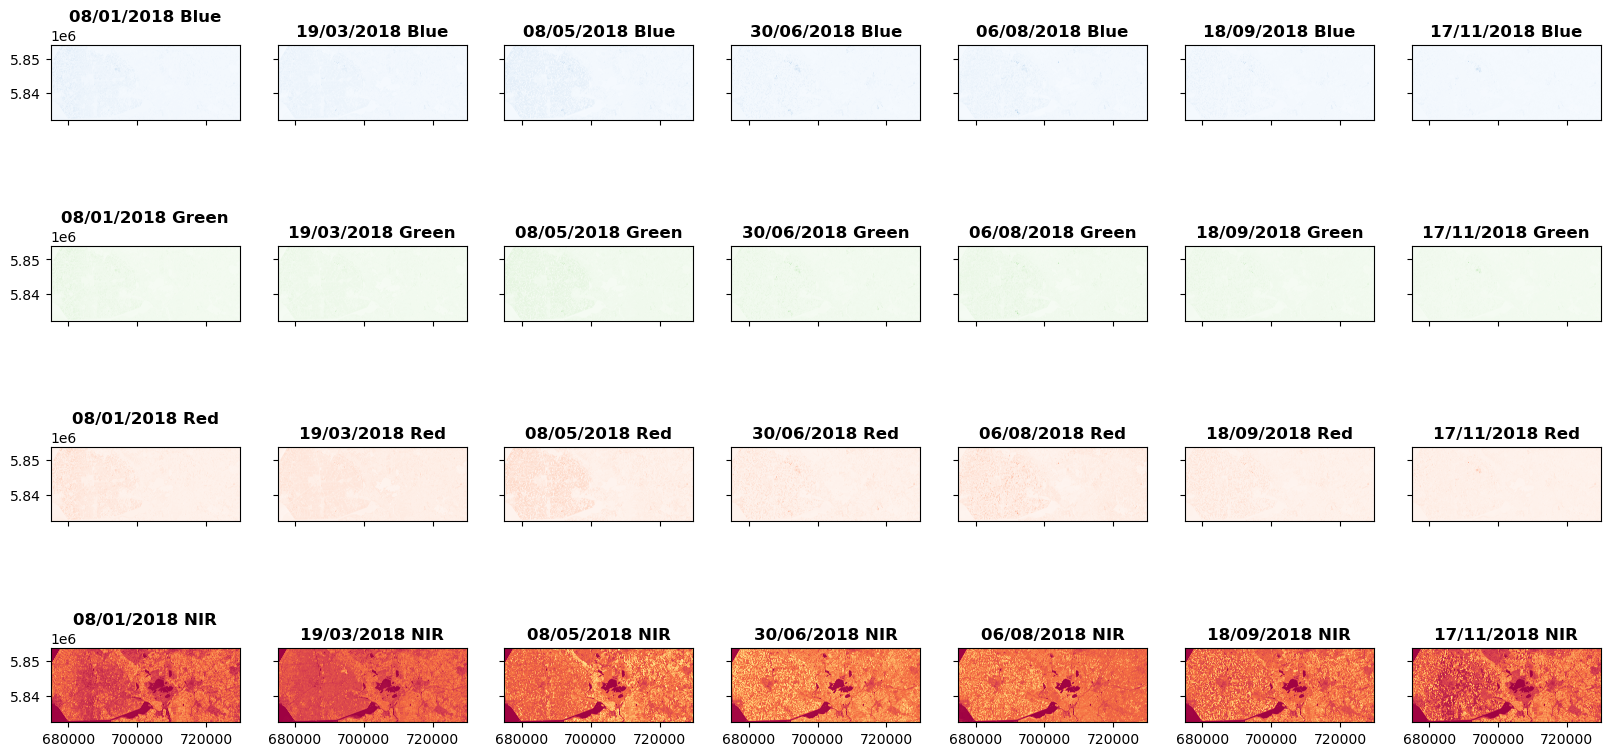

In [5]:
fig, ax = plt.subplots(4, 7, sharex='col', sharey='row', figsize=(20,10))

dates = ['08/01/2018', '19/03/2018', '08/05/2018', '30/06/2018', '06/08/2018', '18/09/2018', '17/11/2018']

for i in range(len(dates)):
    show((input_ds, (i*4)+1), ax=ax[0, i], cmap='Blues', title='%s Blue' % dates[i])
    show((input_ds, (i*4)+2), ax=ax[1, i], cmap='Greens', title='%s Green' % dates[i])
    show((input_ds, (i*4)+3), ax=ax[2, i], cmap='Reds', title='%s Red' % dates[i])
    show((input_ds, (i*4)+4), ax=ax[3, i], cmap='Spectral', title='%s NIR' % dates[i])

## Access the input dataset with GDAL

In [6]:
# try to open the input file with gdal
dataset = gdal.Open(input_file)
if not dataset:
    print("could not read the file")

In [7]:
# get some information from the file
print("Driver: {}/{}".format(dataset.GetDriver().ShortName, dataset.GetDriver().LongName))
print("Size is {} x {} x {}".format(dataset.RasterXSize, dataset.RasterYSize, dataset.RasterCount))
print("Projection is {}".format(dataset.GetProjection()))
geotransform = dataset.GetGeoTransform()
if geotransform:
    print("Origin = ({}, {})".format(geotransform[0], geotransform[3]))
    print("Pixel Size = ({}, {})".format(geotransform[1], geotransform[5]))

Driver: GTiff/GeoTIFF
Size is 5490 x 2170 x 28
Projection is PROJCS["WGS 84 / UTM zone 31N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",3],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32631"]]
Origin = (674900.0, 5853960.0)
Pixel Size = (10.0, -10.0)


In [8]:
# get some raster band information
band = dataset.GetRasterBand(1)
print("Band Type={}".format(gdal.GetDataTypeName(band.DataType)))

min = band.GetMinimum()
max = band.GetMaximum()
if not min or not max:
    (min,max) = band.ComputeRasterMinMax(True)
print("Min={:.3f}, Max={:.3f}".format(min,max))

if band.GetOverviewCount() > 0:
    print("Band has {} overviews".format(band.GetOverviewCount()))

if band.GetRasterColorTable():
    print("Band has a color table with {} entries".format(band.GetRasterColorTable().GetCount()))

Band Type=UInt16
Min=1.000, Max=7267.000


## Read a subset from the input dataset with GDAL and normalise it

In [10]:
# read multiple bands from the dataset into a numpy array
arr = dataset.ReadAsArray(
    xoff=250,
    yoff=200,
    xsize=250,
    ysize=250,
    buf_obj=None,
    buf_xsize=None,
    buf_ysize=None,
    buf_type=None,
    resample_alg=0,
    callback=None,
    callback_data=None,
    interleave='band',
    band_list=None
).astype("float32")

arr.shape

(28, 250, 250)

In [11]:
# normalize the band data before the inference

# This duplicates how the training data was normalized, so that the values
# that we will pass to the model later for inference are in the range it
# expects. Usually somewhere between [-1,1].

def normalize(ds, tile_np):
    for index in range(tile_np.shape[0]):
        band = ds.GetRasterBand(index + 1)
        (_, b_max) = band.ComputeRasterMinMax(True)
        tile_np[index] /= b_max

In [12]:
# normalize the data and check a subset of it
normalize(dataset, arr)

arr[0:1,0:5,0:5]

array([[[0.23943856, 0.23751204, 0.23985139, 0.23957616, 0.23737442],
        [0.24810788, 0.24934636, 0.23930095, 0.23627357, 0.24301638],
        [0.24728224, 0.2512729 , 0.23820008, 0.23654878, 0.23971377],
        [0.2500344 , 0.2417779 , 0.22719142, 0.24576855, 0.24920875],
        [0.24920875, 0.2369616 , 0.23503509, 0.23930095, 0.23324618]]],
      dtype=float32)

## Turn the data into a tensor run it through the model

In [13]:
# re-order the dimensions (if needed) and add a batch dimension
# the model expects: [batch, bands, x, y]
tile = arr.transpose(0,1,2)
tile_t = torch.from_numpy(tile).unsqueeze(dim=0)
tile_t.shape

torch.Size([1, 28, 250, 250])

In [14]:
# check a subset of the tensor
tile_t[:,0:1,0:5,0:5]

tensor([[[[0.2394, 0.2375, 0.2399, 0.2396, 0.2374],
          [0.2481, 0.2493, 0.2393, 0.2363, 0.2430],
          [0.2473, 0.2513, 0.2382, 0.2365, 0.2397],
          [0.2500, 0.2418, 0.2272, 0.2458, 0.2492],
          [0.2492, 0.2370, 0.2350, 0.2393, 0.2332]]]])

In [15]:
# infer the output, take the max index, and remove the batch dimension
# also, ask torch to not waste time on tracking gradients

# The max index refers to the most likely crop class, according to the model.

model.eval()
with torch.no_grad():
    pred = model(tile_t).argmax(1).squeeze()

In [16]:
# check a subset of the predictions
pred.numpy()[0:10,0:15]

array([[23, 23, 23, 23, 23, 23,  9,  9,  9,  1,  1,  6,  6,  6,  6],
       [23, 23, 23, 23, 23, 23, 23,  9, 23,  1,  1,  6,  6,  6,  6],
       [23, 23, 23, 23, 23, 23,  9,  9,  1,  1,  1,  1,  6,  6,  6],
       [23, 23, 23, 23, 23,  9, 23,  9,  1,  1,  1,  1,  4,  4,  9],
       [23, 23, 23, 23, 23,  9,  9,  1,  1,  1,  1,  1,  4,  4,  9],
       [23, 23, 23, 23,  9,  9,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [23, 23, 23,  9,  9,  9,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 9,  9,  9,  9,  9,  9,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 9,  9,  9,  9,  4,  1,  1,  1,  1,  1,  1,  1,  1, 22, 22],
       [ 9,  9, 14,  4,  4,  4,  1, 26, 26, 26,  4,  4, 22, 22, 22]])

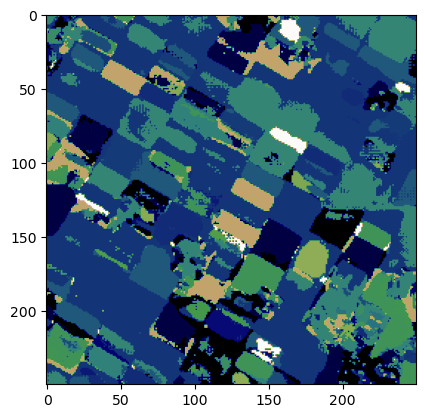

In [17]:
# display as image
# note that the model is not good at creating nice straight parcel boundaries
# the colormap does not represent all 76 crop classes very well
plt.imshow(pred, cmap="gist_earth")

In [18]:
# TODO
#   - loop over tiles to predict full image
#   - write full result to geotiff file with correct CRS

## Rasdaman UDF debugging
The following cells are used for debugging the Rasdaman UDF torch implementation.

To get the same input [250,250,28] directly from Rasdaman:
http://fairicube.rasdaman.com:8080/rasdaman/ows?&SERVICE=WCS&VERSION=2.0.1&REQUEST=GetCoverage&COVERAGEID=sentinel2_2018_flevopolder_10m_7x4bands&SUBSET=E(677400,679900)&SUBSET=N(5849460,5851960)&FORMAT=image/tiff

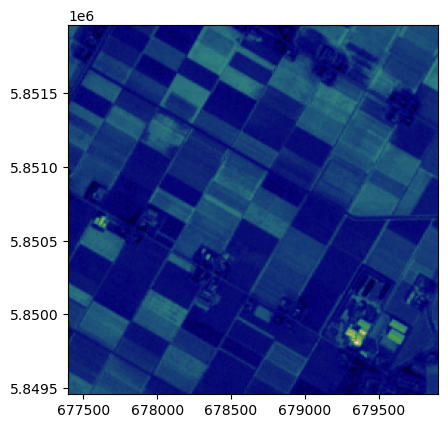

<AxesSubplot: >

In [19]:
sample_tile_file = "../data/raw/sentinel2_2018_flevopolder_10m_7x4bands-tile_2.tiff"
sample_tile_ds = rasterio.open(sample_tile_file)
show(sample_tile_ds, cmap="gist_earth")

## Create a small cutout and run it through the model

In [20]:
# get only a very small cutout (8x8 is the minimum due to conv padding)
# - take 9x9 to have a 'centre' cell to examine
# - the inferred classes at the borders are less stable (lack of data)

x_off  = 250
y_off  = 200
x_size = 250
y_size = 250

arr = dataset.ReadAsArray(xoff=x_off, yoff=y_off, xsize=x_size, ysize=y_size, interleave='band', band_list=None).astype("float32")
sample_x = x_size//2
sample_y = y_size//2
print("coordinates of sample cell             : ", sample_x, sample_y)
print("input centre cell value channel 3      : ", arr[3, sample_x, sample_y])

# normalize it
normalize(dataset, arr)
print("normalized centre cell value channel 3 : ", arr[3, sample_x, sample_y])

# create a tensor from the cutout
tile = arr.transpose(0, 1, 2)
tile_t = torch.from_numpy(tile).unsqueeze(dim=0)
print("input centre tensor value channel 3    : ", tile_t[0, 3, sample_x, sample_y])

# inference
model.eval()
with torch.no_grad():
    pred = model(tile_t)
    pred_class = pred.argmax(1)
    print("inferred centre tensor argmax class    : ", pred_class[0, sample_x, sample_y])
    print("inferred centre tensor argmax proba    : ", pred[0, pred_class[0, sample_x, sample_y], sample_x, sample_y])

## table with all inferred crop classes
pred_class.squeeze().numpy()[0:x_size, 0:y_size]

coordinates of sample cell             :  125 125
input centre cell value channel 3      :  2987.0
normalized centre cell value channel 3 :  0.2326324
input centre tensor value channel 3    :  tensor(0.2326)
inferred centre tensor argmax class    :  tensor(9)
inferred centre tensor argmax proba    :  tensor(9.1081)


array([[23, 23, 23, ...,  9,  9,  9],
       [23, 23, 23, ...,  9,  9,  9],
       [23, 23, 23, ...,  9,  9,  9],
       ...,
       [23,  9, 23, ..., 29, 29, 29],
       [23, 23, 23, ..., 29, 30, 29],
       [23, 23, 23, ..., 30, 30, 30]])

To note: crop class 23 is potatoes, and class 1 is grassland. Both are majority classes in the input dataset.

### Flatten the data and save it to a row-colum-channels CSV file

In [21]:
arr.shape

(28, 250, 250)

In [22]:
chan = arr.shape[0]
rows = arr.shape[1]
cols = arr.shape[2]
arr_t = arr.transpose(1, 2, 0).reshape(rows * cols, 28)
arr_t

array([[0.23943856, 0.25378475, 0.17014858, ..., 0.07445581, 0.07036232,
        0.12770618],
       [0.23751204, 0.25447288, 0.16856475, ..., 0.07635225, 0.07362319,
        0.12590206],
       [0.23985139, 0.26107898, 0.17535259, ..., 0.07907322, 0.07623188,
        0.11907216],
       ...,
       [0.15068117, 0.1527663 , 0.10792669, ..., 0.06827177, 0.05876812,
        0.23079897],
       [0.13760836, 0.14891274, 0.11086809, ..., 0.07041556, 0.05833333,
        0.22435567],
       [0.14393835, 0.14684834, 0.11034015, ..., 0.06348944, 0.05811594,
        0.22023197]], dtype=float32)

In [42]:
import pandas as pd

filename = "sentinel2_normalised_" + str(rows) + "rows_" + str(cols) + "cols_" + str(chan) + "channels.csv"
pd.DataFrame(arr_t).to_csv(filename, index=False, header=False)

### ... continue with torch C++: read the torchscript model, csv data, and perform the same inference ...